<a href="https://colab.research.google.com/github/whitehatjr1001/----HEYMNIST___/blob/main/Hotel_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# New Section

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Homestays_Data .csv')


In [ ]:
df.shape



(74111, 29)

1.Feature Engeneering


> We are using current data to create more features to make our model more accurate




In [ ]:
# Convert 'host_since' to datetime format
current_date = datetime.now()
df['host_since'] = pd.to_datetime(df['host_since'])

# Calculate host tenure in years
current_date = datetime.now()
df['Host_Tenure'] = (current_date - df['host_since']).dt.days / 365.25

# Count the number of amenities for each listing
df['Amenities_Count'] = df['amenities'].apply(lambda x: len(x.split(',')))

# Convert 'last_review' to datetime format
df['last_review'] = pd.to_datetime(df['last_review'])

# Calculate days since last review
df['Days_Since_Last_Review'] = (current_date - df['last_review']).dt.days




<ipython-input-5-03c9c54ea224>:3: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['host_since'] = pd.to_datetime(df['host_since'])
<ipython-input-5-03c9c54ea224>:13: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['last_review'] = pd.to_datetime(df['last_review'])


In [ ]:
df['Host_Tenure']

0        12.117728
1         6.885695
2         7.534565
3         9.054073
4         9.188227
           ...    
74106    11.123888
74107     8.013689
74108    12.339493
74109     6.639288
74110    11.446954
Name: Host_Tenure, Length: 74111, dtype: float64

In [ ]:
df['host_since']

0       2012-03-26
1       2017-06-19
2       2016-10-25
3       2015-04-19
4       2015-03-01
           ...    
74106   2013-03-24
74107   2016-05-03
74108   2012-01-05
74109   2017-09-17
74110   2012-11-26
Name: host_since, Length: 74111, dtype: datetime64[ns]

In [ ]:
# Concatenate the engineered features to the main DataFrame
df = pd.concat([df,
                df[['Host_Tenure', 'Amenities_Count', 'Days_Since_Last_Review']]],
               axis=1)


In [ ]:
# Drop duplicate columns
df = df.loc[:, ~df.columns.duplicated()]

# Check the columns after removing duplicates
print(df.columns)


Index(['id', 'log_price', 'property_type', 'room_type', 'amenities',
       'accommodates', 'bathrooms', 'bed_type', 'cancellation_policy',
       'cleaning_fee', 'city', 'description', 'first_review',
       'host_has_profile_pic', 'host_identity_verified', 'host_response_rate',
       'host_since', 'instant_bookable', 'last_review', 'latitude',
       'longitude', 'name', 'neighbourhood', 'number_of_reviews',
       'review_scores_rating', 'thumbnail_url', 'zipcode', 'bedrooms', 'beds',
       'Host_Tenure', 'Amenities_Count', 'Days_Since_Last_Review'],
      dtype='object')


In [ ]:
df.isna().count()

id                        74111
log_price                 74111
property_type             74111
room_type                 74111
amenities                 74111
accommodates              74111
bathrooms                 74111
bed_type                  74111
cancellation_policy       74111
cleaning_fee              74111
city                      74111
description               74111
first_review              74111
host_has_profile_pic      74111
host_identity_verified    74111
host_response_rate        74111
host_since                74111
instant_bookable          74111
last_review               74111
latitude                  74111
longitude                 74111
name                      74111
neighbourhood             74111
number_of_reviews         74111
review_scores_rating      74111
thumbnail_url             74111
zipcode                   74111
bedrooms                  74111
beds                      74111
Host_Tenure               74111
Amenities_Count           74111
Days_Sin

2 EDA(Exploratery data analysis)

Text(0.5, 1.0, 'Distribution of Room Type')

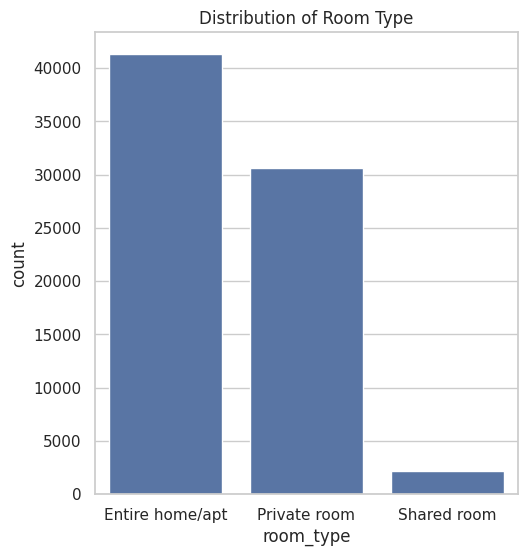

In [ ]:
sns.set(style="whitegrid")

# 1. Categorical Features Analysis
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.countplot(x='room_type', data=df)
plt.title('Distribution of Room Type')

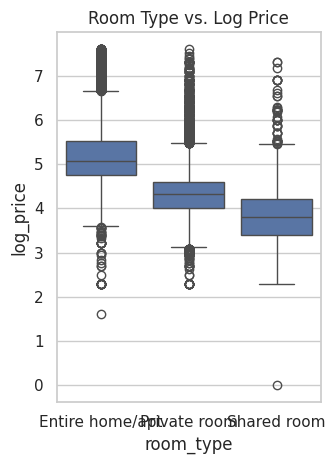

In [ ]:
plt.subplot(1, 2, 2)
sns.boxplot(x='room_type', y='log_price', data=df)
plt.title('Room Type vs. Log Price')
plt.tight_layout()
plt.show()

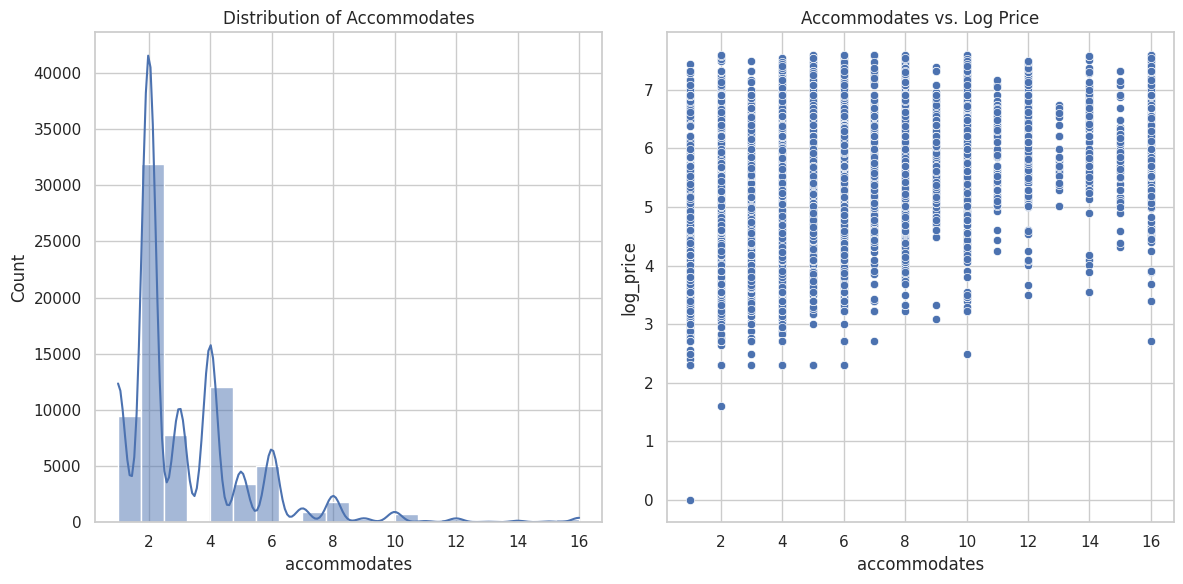

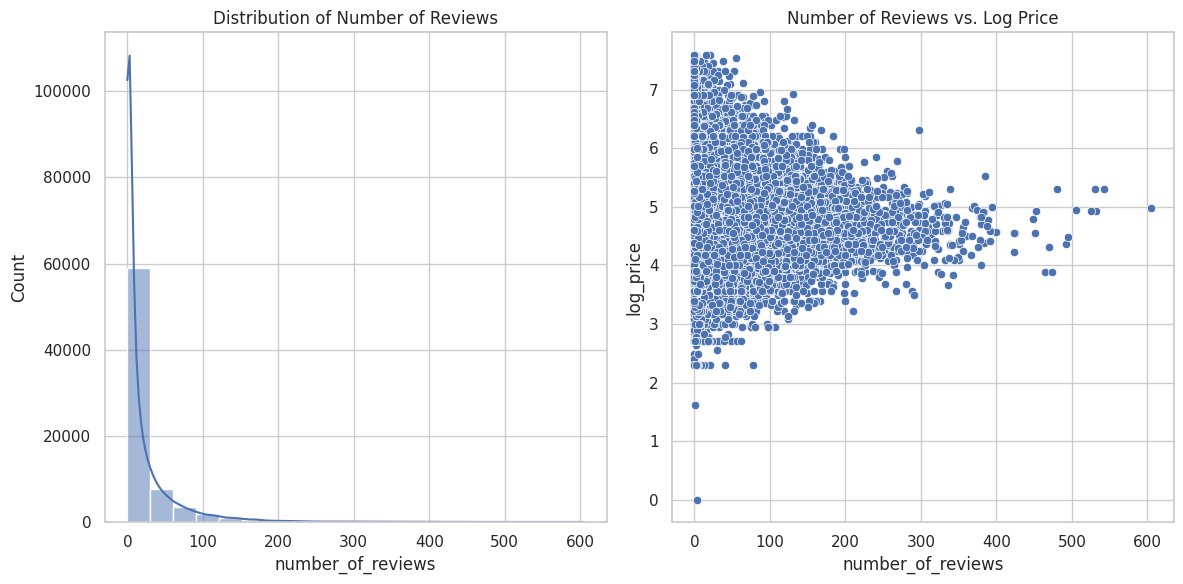

In [ ]:
# 2. Numerical Features Analysis
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(df['accommodates'], bins=20, kde=True)
plt.title('Distribution of Accommodates')

plt.subplot(1, 2, 2)
sns.scatterplot(x='accommodates', y='log_price', data=df)
plt.title('Accommodates vs. Log Price')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(df['number_of_reviews'], bins=20, kde=True)
plt.title('Distribution of Number of Reviews')

plt.subplot(1, 2, 2)
sns.scatterplot(x='number_of_reviews', y='log_price', data=df)
plt.title('Number of Reviews vs. Log Price')
plt.tight_layout()
plt.show()

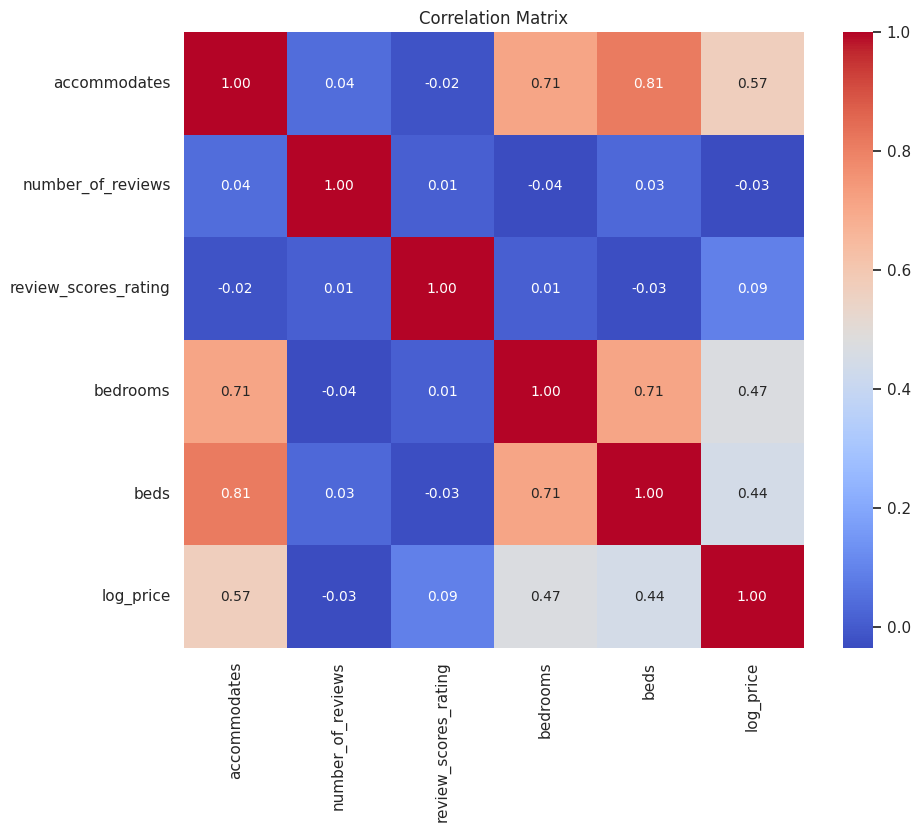

In [ ]:
# 3. Correlation Analysis
numerical_features = ['accommodates', 'number_of_reviews', 'review_scores_rating', 'bedrooms', 'beds']
correlation_matrix = df[numerical_features + ['log_price']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 10})
plt.title('Correlation Matrix')
plt.show()

3 Geo spatial analysis


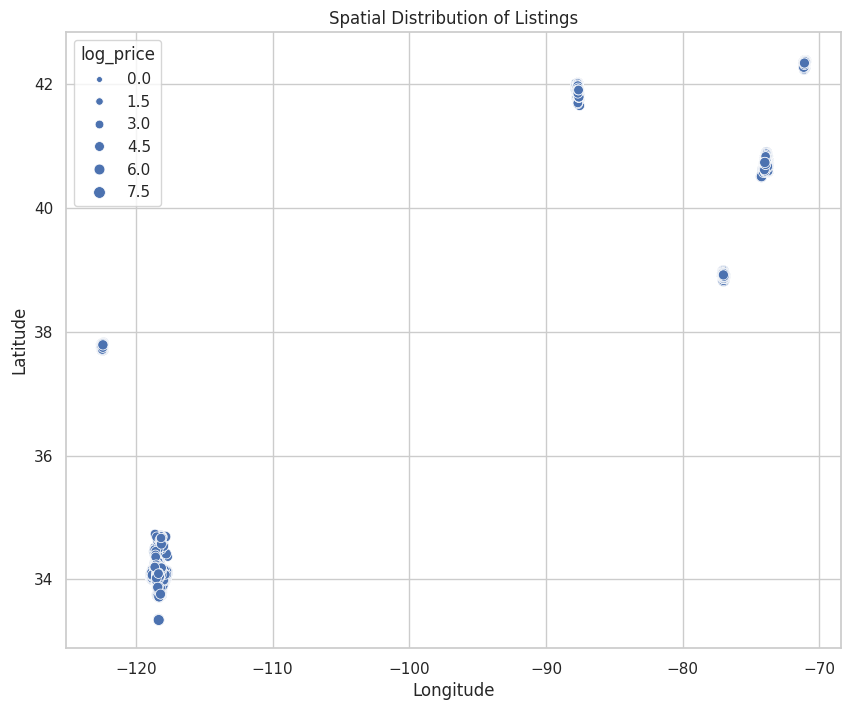

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter plot of listings with latitude and longitude
plt.figure(figsize=(10, 8))
sns.scatterplot(x='longitude', y='latitude', size='log_price', data=df, alpha=1)
plt.title('Spatial Distribution of Listings')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


In [ ]:
df.dtypes

id                                 int64
log_price                        float64
property_type                     object
room_type                         object
amenities                         object
accommodates                       int64
bathrooms                        float64
bed_type                          object
cancellation_policy               object
cleaning_fee                        bool
city                              object
description                       object
first_review                      object
host_has_profile_pic              object
host_identity_verified            object
host_response_rate                object
host_since                datetime64[ns]
instant_bookable                  object
last_review               datetime64[ns]
latitude                         float64
longitude                        float64
name                              object
neighbourhood                     object
number_of_reviews                  int64
review_scores_ra

4 Amanties analysis


In [ ]:
# Step 1: Parse Amenities
# Assuming df is your DataFrame containing the data
df['amenities_list'] = df['amenities'].str.strip('{}').str.split(',')

# Step 2: Data Preprocessing
# Encode categorical variables, handle missing values if any

# Step 3: Statistical Analysis
# Define the list of unique amenities
amenities = set([amenity for amenities_list in df['amenities_list'] for amenity in amenities_list])

# Calculate correlation between each amenity and prices
amenities_corr = df['amenities_list'].apply(lambda x: pd.Series([1 if amenity in x else 0 for amenity in amenities]))
amenities_corr['log_price'] = df['log_price']

# Calculate correlation matrix
correlation_matrix = amenities_corr.corr()

# Step 4: Visualization
plt.figure(figsize=(100,100))
sns.heatmap(correlation_matrix[['log_price']], annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 100})
plt.title('Correlation between Amenities and Log Price')
plt.show()

In [ ]:

df.drop(columns=['description'], inplace=True)


In [ ]:
# Print the column names of your DataFrame
print(df.columns)


Index(['id', 'log_price', 'property_type', 'room_type', 'amenities',
       'accommodates', 'bathrooms', 'bed_type', 'cancellation_policy',
       'cleaning_fee', 'city', 'first_review', 'host_has_profile_pic',
       'host_identity_verified', 'host_response_rate', 'host_since',
       'instant_bookable', 'last_review', 'latitude', 'longitude', 'name',
       'neighbourhood', 'number_of_reviews', 'review_scores_rating',
       'thumbnail_url', 'zipcode', 'bedrooms', 'beds', 'Host_Tenure',
       'Amenities_Count', 'Days_Since_Last_Review'],
      dtype='object')


ENcoding data based on the anylysis


In [ ]:
# Select categorical columns to be one-hot encoded
categorical_cols = ['bed_type', 'cancellation_policy','room_type', 'city', 'property_type']

# Perform one-hot encoding on the selected categorical columns
df_encoded_ = pd.get_dummies(df, columns=categorical_cols)

# Display the first few rows of the encoded DataFrame
print(df_encoded_.head())

         id  log_price                                          amenities  \
0   6901257   5.010635  {"Wireless Internet","Air conditioning",Kitche...   
1   6304928   5.129899  {"Wireless Internet","Air conditioning",Kitche...   
2   7919400   4.976734  {TV,"Cable TV","Wireless Internet","Air condit...   
3  13418779   6.620073  {TV,"Cable TV",Internet,"Wireless Internet",Ki...   
4   3808709   4.744932  {TV,Internet,"Wireless Internet","Air conditio...   

   accommodates  bathrooms  cleaning_fee first_review host_has_profile_pic  \
0             3        1.0          True   18-06-2016                    t   
1             7        1.0          True   05-08-2017                    t   
2             5        1.0          True   30-04-2017                    t   
3             4        1.0          True          NaN                    t   
4             2        1.0          True   12-05-2015                    t   

  host_identity_verified host_response_rate  ...  \
0               

In [ ]:
df_encoded_.columns

Index(['id', 'log_price', 'amenities', 'accommodates', 'bathrooms',
       'cleaning_fee', 'first_review', 'host_has_profile_pic',
       'host_identity_verified', 'host_response_rate', 'host_since',
       'instant_bookable', 'last_review', 'latitude', 'longitude', 'name',
       'neighbourhood', 'number_of_reviews', 'review_scores_rating',
       'thumbnail_url', 'zipcode', 'bedrooms', 'beds', 'Host_Tenure',
       'Amenities_Count', 'Days_Since_Last_Review', 'bed_type_Airbed',
       'bed_type_Couch', 'bed_type_Futon', 'bed_type_Pull-out Sofa',
       'bed_type_Real Bed', 'cancellation_policy_flexible',
       'cancellation_policy_moderate', 'cancellation_policy_strict',
       'cancellation_policy_super_strict_30',
       'cancellation_policy_super_strict_60', 'room_type_Entire home/apt',
       'room_type_Private room', 'room_type_Shared room', 'city_Boston',
       'city_Chicago', 'city_DC', 'city_LA', 'city_NYC', 'city_SF',
       'property_type_Apartment', 'property_type_Bed & 

In [ ]:
# List of True/False columns
boolean_cols = ['cleaning_fee', 'host_has_profile_pic', 'host_identity_verified', 'instant_bookable','property_type_Apartment', 'property_type_Bed & Breakfast',
       'property_type_Boat', 'property_type_Boutique hotel',
       'property_type_Bungalow', 'property_type_Cabin',
       'property_type_Camper/RV', 'property_type_Casa particular',
       'property_type_Castle', 'property_type_Cave', 'property_type_Chalet',
       'property_type_Condominium', 'property_type_Dorm',
       'property_type_Earth House', 'property_type_Guest suite',
       'property_type_Guesthouse', 'property_type_Hostel',
       'property_type_House', 'property_type_Hut', 'property_type_In-law',
       'property_type_Island', 'property_type_Lighthouse',
       'property_type_Loft', 'property_type_Other',
       'property_type_Parking Space', 'property_type_Serviced apartment',
       'property_type_Tent', 'property_type_Timeshare', 'property_type_Tipi',
       'property_type_Townhouse', 'property_type_Train',
       'property_type_Treehouse', 'property_type_Vacation home',
       'property_type_Villa', 'property_type_Yurt',
       'room_type_Entire home/apt', 'room_type_Private room',
       'room_type_Shared room', 'city_Boston', 'city_Chicago', 'city_DC',
       'city_LA', 'city_NYC', 'city_SF', 'bed_type_Airbed', 'bed_type_Couch',
       'bed_type_Futon', 'bed_type_Pull-out Sofa', 'bed_type_Real Bed',
       'cancellation_policy_flexible', 'cancellation_policy_moderate',
       'cancellation_policy_strict', 'cancellation_policy_super_strict_30',
       'cancellation_policy_super_strict_60']

for col in boolean_cols:
    unique_values = df_encoded_[col].unique()
    print(f"Unique values in {col}: {unique_values}")

Unique values in cleaning_fee: [ True False]
Unique values in host_has_profile_pic: ['t' nan 'f']
Unique values in host_identity_verified: ['t' 'f' nan]
Unique values in instant_bookable: ['f' 't']
Unique values in property_type_Apartment: [ True False]
Unique values in property_type_Bed & Breakfast: [False  True]
Unique values in property_type_Boat: [False  True]
Unique values in property_type_Boutique hotel: [False  True]
Unique values in property_type_Bungalow: [False  True]
Unique values in property_type_Cabin: [False  True]
Unique values in property_type_Camper/RV: [False  True]
Unique values in property_type_Casa particular: [False  True]
Unique values in property_type_Castle: [False  True]
Unique values in property_type_Cave: [False  True]
Unique values in property_type_Chalet: [False  True]
Unique values in property_type_Condominium: [False  True]
Unique values in property_type_Dorm: [False  True]
Unique values in property_type_Earth House: [False  True]
Unique values in proper

In [ ]:
# List of boolean columns
boolean_cols = ['host_has_profile_pic', 'host_identity_verified', 'instant_bookable']

# Convert boolean columns to binary (0/1)
for col in boolean_cols:
    df_encoded_[col] = df_encoded_[col].map({'f': 0, 't': 1})


In [ ]:
df_encoded_.dtypes

id                               int64
log_price                      float64
amenities                       object
accommodates                     int64
bathrooms                      float64
                                ...   
property_type_Train               bool
property_type_Treehouse           bool
property_type_Vacation home       bool
property_type_Villa               bool
property_type_Yurt                bool
Length: 80, dtype: object

In [ ]:
df_encoded_['host_response_rate'].dtype

dtype('O')

In [ ]:

# Select only boolean columns
boolean_cols = df_encoded_.select_dtypes(include=bool).columns

# Convert boolean columns to 0 and 1
df_encoded_[boolean_cols] = df_encoded_[boolean_cols].astype(int)

In [ ]:


# Remove the percentage sign from 'host_response_rate' column and convert to numeric
df_encoded_['host_response_rate'] = df_encoded_['host_response_rate'].str.rstrip('%').astype(float)

# Fill missing values with 0 and convert to integers
df_encoded_['host_response_rate'] = df_encoded_['host_response_rate'].fillna(0).astype(int)

# Display the first few rows of the DataFrame after encoding
df_encoded_.head()


,id,log_price,amenities,accommodates,bathrooms,cleaning_fee,first_review,host_has_profile_pic,host_identity_verified,host_response_rate,...,property_type_Serviced apartment,property_type_Tent,property_type_Timeshare,property_type_Tipi,property_type_Townhouse,property_type_Train,property_type_Treehouse,property_type_Vacation home,property_type_Villa,property_type_Yurt
0,6901257,5.010635,"{""Wireless Internet"",""Air conditioning"",Kitche...",3,1.0,1,18-06-2016,1.0,1.0,0,...,0,0,0,0,0,0,0,0,0,0
1,6304928,5.129899,"{""Wireless Internet"",""Air conditioning"",Kitche...",7,1.0,1,05-08-2017,1.0,0.0,100,...,0,0,0,0,0,0,0,0,0,0
2,7919400,4.976734,"{TV,""Cable TV"",""Wireless Internet"",""Air condit...",5,1.0,1,30-04-2017,1.0,1.0,100,...,0,0,0,0,0,0,0,0,0,0
3,13418779,6.620073,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",4,1.0,1,NaN,1.0,1.0,0,...,0,0,0,0,0,0,0,0,0,0
4,3808709,4.744932,"{TV,Internet,""Wireless Internet"",""Air conditio...",2,1.0,1,12-05-2015,1.0,1.0,100,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df_encoded_.columns

Index(['id', 'log_price', 'amenities', 'accommodates', 'bathrooms',
       'cleaning_fee', 'first_review', 'host_has_profile_pic',
       'host_identity_verified', 'host_response_rate', 'host_since',
       'instant_bookable', 'last_review', 'latitude', 'longitude', 'name',
       'neighbourhood', 'number_of_reviews', 'review_scores_rating',
       'thumbnail_url', 'zipcode', 'bedrooms', 'beds', 'Host_Tenure',
       'Amenities_Count', 'Days_Since_Last_Review', 'bed_type_Airbed',
       'bed_type_Couch', 'bed_type_Futon', 'bed_type_Pull-out Sofa',
       'bed_type_Real Bed', 'cancellation_policy_flexible',
       'cancellation_policy_moderate', 'cancellation_policy_strict',
       'cancellation_policy_super_strict_30',
       'cancellation_policy_super_strict_60', 'room_type_Entire home/apt',
       'room_type_Private room', 'room_type_Shared room', 'city_Boston',
       'city_Chicago', 'city_DC', 'city_LA', 'city_NYC', 'city_SF',
       'property_type_Apartment', 'property_type_Bed & 

In [ ]:
df_encoded_.drop(columns=['amenities','latitude', 'longitude', 'name','thumbnail_url',], inplace=True)

In [ ]:
df_encoded_.drop(columns=['host_since'], inplace=True)

In [ ]:
df_encoded_.drop(columns=['first_review'], inplace=True)

In [ ]:
df_encoded_.dtypes

id                               int64
log_price                      float64
accommodates                     int64
bathrooms                      float64
cleaning_fee                     int64
                                ...   
property_type_Train              int64
property_type_Treehouse          int64
property_type_Vacation home      int64
property_type_Villa              int64
property_type_Yurt               int64
Length: 73, dtype: object

In [ ]:
# Remove rows with NaN values
df_cleaned = df_encoded_.dropna()

# Verify the shape of the cleaned dataset
print("Original shape:", df_encoded_.shape)
print("Shape after removing rows with NaN values:", df_cleaned.shape)

Original shape: (74111, 73)
Shape after removing rows with NaN values: (51552, 73)


In [ ]:
X = df_cleaned.drop('log_price', axis=1)
y = df_cleaned['log_price']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Convert datetime columns to numerical features
X_train['last_review'] = (X_train['last_review'] - X_train['last_review'].min()).dt.days
# Similarly, preprocess other datetime columns if needed

# Handle object columns using label encoding
label_encoder = LabelEncoder()
X_train['neighbourhood'] = label_encoder.fit_transform(X_train['neighbourhood'])
X_train['zipcode'] = label_encoder.fit_transform(X_train['zipcode'])

In [ ]:
# Convert datetime columns to numerical features
X_test['last_review'] = (X_test['last_review'] - X_test['last_review'].min()).dt.days
# Similarly, preprocess other datetime columns if needed

# Handle object columns using label encoding
label_encoder = LabelEncoder()
X_test['neighbourhood'] = label_encoder.fit_transform(X_test['neighbourhood'])
X_test['zipcode'] = label_encoder.fit_transform(X_test['zipcode'])

In [ ]:
X_train_array = X_train.values
X_test_array = X_test.values
y_train_array = y_train.values
y_test_array = y_test.values


In [ ]:
X_train

In [ ]:
# Import necessary libraries
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
# Define your models
random_forest_reg = RandomForestRegressor()

# Fit the models to the training data
random_forest_reg.fit(X_train_array, y_train_array)

# Make predictions on the testing set
y_pred_rf = random_forest_reg.predict(X_test_array)

# Calculate RMSE for each model
rmse_rf = np.sqrt(mean_squared_error(y_test_array, y_pred_rf))
print("RMSE for Random Forest Regression:", rmse_rf)

# GradientBoosting Model
gb_reg = GradientBoostingRegressor()
gb_reg.fit(X_train, y_train)
y_pred_gb = gb_reg.predict(X_test)
rmse_gb = np.sqrt(mean_squared_error(y_test, y_pred_gb))
print("RMSE GradientBoosting:", rmse_gb)



RMSE for Random Forest Regression: 0.3898019060176565
RMSE GradientBoosting: 0.3871256622556331


In [ ]:
xgb_reg = XGBRegressor()
xgb_reg.fit(X_train_array, y_train_array)

# Make predictions on the testing set
y_pred = xgb_reg.predict(X_test_array)

# Evaluate the model
mse = mean_squared_error(y_test_array, y_pred)
rmse = np.sqrt(mse)
print("Root Mean Squared Error:", rmse)

Root Mean Squared Error: 0.4020880322714401


In [ ]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 7.2 MB/s eta 0:00:00


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, make_scorer
import shap

# Task 8: Model Optimization and Validation
# Define a custom scorer using RMSE
rmse_scorer = make_scorer(mean_squared_error, squared=False)

# Define the parameter grid for Grid Search
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2, 3],
}

# Perform Grid Search Cross Validation for Gradient Boosting
grid_search = GridSearchCV(estimator=GradientBoostingRegressor(),
                           param_grid=param_grid, scoring=rmse_scorer, cv=5)
grid_search.fit(X_train_array, y_train_array)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = np.sqrt(-grid_search.best_score_)

print("Best Parameters:", best_params)
print("Best RMSE:", best_score)

# Task 9: Feature Importance and Model Insights
# Fit the final model with the best parameters
final_gb_reg = GradientBoostingRegressor(**best_params)
final_gb_reg.fit(X_train_array, y_train_array)

# Calculate feature importance scores
feature_importance = final_gb_reg.feature_importances_

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(X_train_array.columns, feature_importance)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Gradient Boosting Feature Importance')
plt.show()

# Compute SHAP values
explainer = shap.Explainer(final_gb_reg)
shap_values = explainer.shap_values(X_train_array)

# Plot SHAP summary plot
shap.summary_plot(shap_values, X_train_array, plot_type='bar', show=False)
plt.title('SHAP Summary Plot')
plt.show()
